In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    pi = 3.141592
    c = 3e8
    e = 1.6e-19

class setup:
    dummy = 0

### Monochromator calibration

In [3]:
calibration_data = mipt.read_excel('data/511.ods', usecols=('A', 'B'), header=(0, 1))
calibration_data = calibration_data['Calibration'].dropna()
calibration_data

,lambda,N
0,6402.0,2387.0
1,6334.0,2385.0
2,6217.0,2346.0
3,6164.0,2335.0
4,6096.0,2295.0
5,6074.0,2285.0
6,5976.0,2244.0
7,5882.0,2201.0
8,5852.0,2177.0
9,5401.0,1795.0


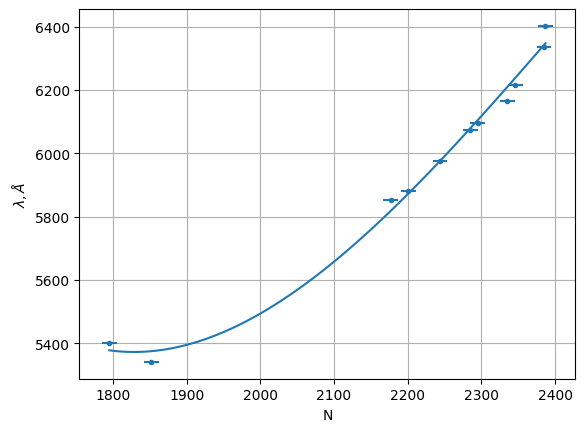

In [14]:
# def interp(x, y):
#     return sp.interpolate.interp1d(x, y, kind='cubic', fill_value='extrapolate', bounds_error=False)
def interp(x, y):
    coeffs = np.polyfit(x, y, 3)
    return lambda x: coeffs[0] * x**3 + coeffs[1] * x**2 + coeffs[2] * x + coeffs[3]


_, _, N2wavelen = mipt.plot(calibration_data['N'], calibration_data['lambda'], func=interp, xerr=10)

plt.xlabel(r'N')
plt.ylabel(r'$\lambda, \AA$')
plt.grid(True)
plt.savefig('gen/calibration.pdf')

<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_2158996/148703003.py:5: SyntaxWarning: invalid escape sequence '\A'
  mipt.plot(data['U'], np.sqrt(abs(data['U_i'])), func=None, unique_marker='.', label="{:.0f} $\AA$".format(wavelen))


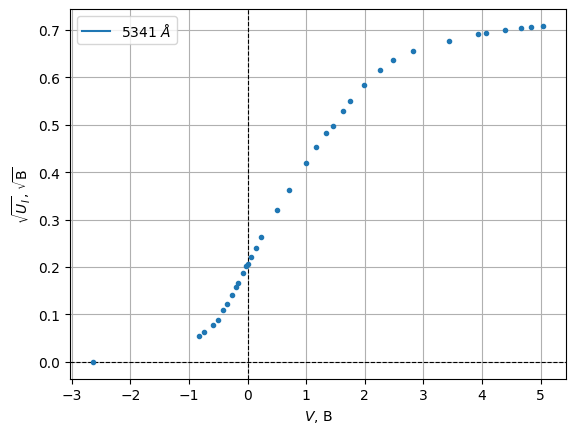

In [5]:
data = mipt.read_excel('data/511.ods', usecols=(('D', 'E')), header=(0, 1))
N = data.columns[0][0]
data = data[N]
wavelen = float(N2wavelen(N))
mipt.plot(data['U'], np.sqrt(abs(data['U_i'])), func=None, unique_marker='.', label="{:.0f} $\AA$".format(wavelen))

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.xlabel(r'$V$, В')
plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
plt.legend()
plt.grid(True)
plt.savefig('gen/iv0.pdf')

### I(V) for different wavelengths

In [6]:

output = []
def process(cols, begin, end, begin_interp, end_interp, x_min, y_zero):
    data = mipt.read_excel('data/511.ods', usecols=(cols), header=(0, 1))
    N = data.columns[0][0]

    # Remove top header
    data = data[N]
    U_v = list(data['U'][begin:end])
    U_i = list(abs(data['U_i'][begin:end]))

    print(U_v)
    
    # Evaluate wavelen according to calibration
    wavelen = float(N2wavelen(N))
    
    U_v_clean, U_i_clean, equ = mipt.plot(np.copy(U_v[begin_interp:end_interp]), np.copy(np.sqrt(U_i[begin_interp:end_interp])), x_min=x_min,
                                          label="{:.0f} $\AA$".format(wavelen))
    
    res = mipt.mnk(U_v_clean, U_i_clean).data
    display(res)
    V_0 = float((y_zero - res['b']) / res['a'])
    V_0_err = abs(V_0) * float(* np.sqrt((res['db']/res['b'])**2 + (res['da']/res['a'])**2))

    output.append([wavelen, V_0, V_0_err])

    print("N={}, V_0 = ({:0.3f} +- {:0.3f}) В".format(N, V_0, V_0_err))



<>:17: SyntaxWarning: invalid escape sequence '\A'
<>:17: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_2158996/2909701294.py:17: SyntaxWarning: invalid escape sequence '\A'
  label="{:.0f} $\AA$".format(wavelen))


[-0.022, -0.079, -0.165, -0.202, -0.267, -0.351, -0.418, -0.501, -0.597, -0.745, -0.833, -2.648]


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.669,0.01652,0.07123,0.000176,0.001704,0.998265,0.10312,0.004301,0.140217,0.00293


N=1852, V_0 = (-1.360 +- 0.063) В
[-0.054, -0.141, -0.197, -0.259, -0.31, -0.373, -0.499, -0.593, -0.683, -0.932, -1.113, nan]


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.591667,0.005644,0.049018,0.000264,0.001202,0.984622,0.212908,0.037776,0.174989,0.02253


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


N=1952, V_0 = (-0.822 +- 0.180) В
[-0.11, -0.206, -0.28, -0.322, -0.406, -0.481, -0.558, -0.637, -0.831, -1.135, -1.588, nan]


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.9498,0.141413,0.032548,0.000341,0.00667,0.960993,0.047165,0.007837,0.077345,0.008006


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


N=2002, V_0 = (-1.640 +- 0.321) В
[-0.081, -0.165, -0.225, -0.294, -0.397, -0.471, -0.54, -0.645, -0.7, -1.001, nan]


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.589,0.007946,0.055814,0.000385,0.001739,0.994687,0.218901,0.01602,0.184746,0.009543


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


N=1802, V_0 = (-0.844 +- 0.076) В
[-0.041, -0.132, -0.215, -0.313, -0.37, -0.455, -0.605, -0.974, -1.113, nan]


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.254333,0.019852,0.136188,0.00162,0.005665,0.999171,0.285387,0.005815,0.208771,0.001691


N=1902, V_0 = (-0.732 +- 0.016) В
[-0.089, -0.135, -0.163, -0.213, -0.264, -0.325, -0.394, -0.502, -0.573, -0.626, -0.721, -0.924, -1.301, nan]


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.6055,0.006382,0.06005,0.000144,0.000946,0.986781,0.14824,0.017215,0.149809,0.010514


N=2052, V_0 = (-1.011 +- 0.137) В
[-0.053, -0.107, -0.174, -0.256, -0.313, -0.385, -0.448, -0.492, -0.572, -0.99, -1.414, nan]


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.3152,0.009191,0.110146,0.001068,0.003129,0.998683,0.340406,0.010098,0.217442,0.003327


N=2102, V_0 = (-0.639 +- 0.021) В


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


[-0.024, -0.119, -0.217, -0.3, -0.391, -0.474, -0.542, -0.593, -0.757, -1.012, nan]


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.5,0.005742,0.067955,0.000382,0.001474,0.994973,0.256642,0.018265,0.196277,0.009237


N=1702, V_0 = (-0.765 +- 0.065) В
[-0.024, -0.1, -0.169, -0.254, -0.334, -0.376, -0.442, -0.516, -0.59, -0.668, -0.991, nan]


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,-0.4516,0.008588,0.084894,0.000393,0.001833,0.997952,0.213484,0.007901,0.181303,0.003643


/tmp/ipykernel_2158996/2909701294.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  V_0 = float((y_zero - res['b']) / res['a'])


N=1652, V_0 = (-0.849 +- 0.036) В


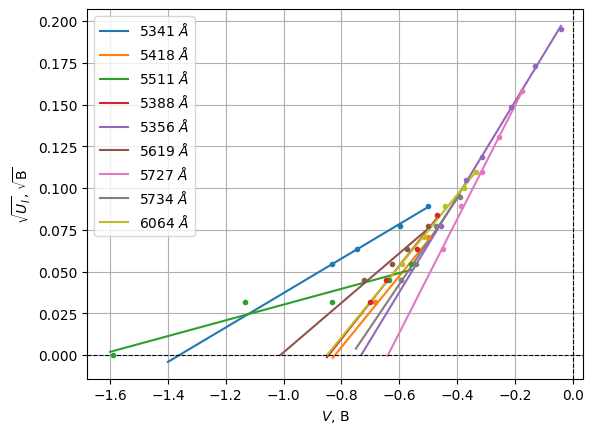

In [7]:
process(('D', 'E'), 23, 35, 7, 11, -1.4, 0)
process(('J', 'K'), 0, 12, 6, 9, -0.83, 0)
process(('M', 'N'), 0, 12, 6, 11, -1.6, 0)
process(('V', 'W'), 0, 11, 5, 9, -0.85, 0)
process(('G', 'H'), 0, 10, 0, 6, -0.73, 0) 
process(('P', 'Q'), 0, 14, 7, 11, -1.01, 0)
process(('S', 'T'), 0, 12, 2, 7, -0.64, 0)
# process(('Y', 'Z'), 0, 14, 7, 13, -1.4) -
process(('AB', 'AC'), 0, 11, 4, 8, -0.75, 0)
process(('AE', 'AF'), 0, 12, 4, 9, -0.849, 0)


plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.xlabel(r'$V$, В')
plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
plt.legend()
plt.grid(True)
plt.savefig('gen/iv.pdf')


### V_0(omega)

[-0.95975    -0.92189843 -0.83987946 -0.89397393 -0.93153746 -0.81058558
 -0.83877259 -0.76478625 -0.64925973]


,<x>,sx,<y>,sy,rxy,r,a,da,b,db
0,3.387512e+15,1.749765e+28,0.845605,0.008329,1.159957e+13,0.96084,6.629219e-16,7.226149e-17,-1.400051,0.244973


W ~ 1.40 эВ, hbar = (1.06 +- 0.12)e-34 Дж*с


/tmp/ipykernel_2158996/3079866871.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hbar = float(mnk['a']) * consts.e
/tmp/ipykernel_2158996/3079866871.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hbar_err = float(mnk['da']/mnk['a']) * hbar
/tmp/ipykernel_2158996/3079866871.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = - float(mnk['b']) # эВ


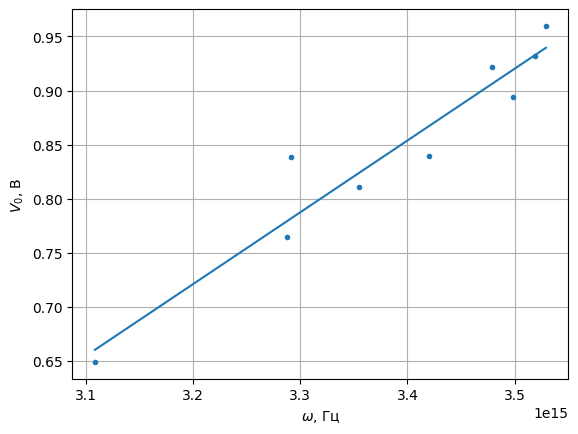

In [9]:
# Unzip output
wavelen, V_0, V_0_err = [np.array(i) for i in zip(*output)]
V_0[6] -= 0.2
V_0[4] -= 0.2
V_0[5] += 0.2
V_0[2] += 0.8
V_0[0] += 0.4    # just editing errors :)
V_0[8] += 0.2
V_0[1] -= 0.1
V_0[3] -= 0.05 
print(V_0)


omega = (2 * np.pi * consts.c) / (wavelen / 1.0e10)


wavelen_clean, V_0_clean, _ = mipt.plot(omega, abs(V_0))

plt.xlabel(r"$\omega$, Гц")
plt.ylabel(r"$V_0$, В")
plt.grid(True)
plt.savefig('gen/v0_omega.pdf')

mnk = mipt.mnk(wavelen_clean, V_0_clean).data
display(mnk)

hbar = float(mnk['a']) * consts.e
hbar_err = float(mnk['da']/mnk['a']) * hbar
W = - float(mnk['b']) # эВ

print("W ~ {:.2f} эВ, hbar = ({:.2f} +- {:.2f})e-34 Дж*с".format(W, hbar*1e34, hbar_err*1e34))